Project 3: Classification

The goal of this project is to build a machine learning model to predict a category for a dataset.

For this project, I use Sonoma County's Animal Shelter Intake and Outake data to predict the likelihood an animal will be returned from adoption.

In this notebook, I do exploratory data analysis on my data and examine how to approach my classification model.

### Table of Contents
1. Imports
2. Exploratory Data Analysis
3. Classification Pre-work

### 1. Imports

In [1]:
import pandas as pd
import numpy as np
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
# Regression imports
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

### 2. Exploratory Data Analysis

In [2]:
# Open the latest cleaned animal_df
with open("data/animal_cleaned_df.pickle", 'rb') as read_file:
    animal_df = pickle.load(read_file)

In [4]:
animal_df.head()

,name,type,breed,color,sex,size,date_of_birth,intake_date,days_in_shelter,intake_type,...,breed_1,breed_2,clean_name,has_name,age,top_breeds,top_colors,pit_bull,adopt_return,intake_location
0,NICO,DOG,POMERANIAN,BROWN,Male,MED,2016-02-01,2020-07-12,0,STRAY,...,POMERANIAN,NaN,NICO,1,5.0,OTHER,BROWN,0,0,SANTA ROSA
1,NaN,DOG,PIT BULL/MIX,BLACK/WHITE,Female,MED,NaT,2020-07-12,0,STRAY,...,PIT BULL,MIX,NaN,0,NaN,PIT BULL/MIX,BLACK/WHITE,1,0,SONOMA COUNTY
2,SKY,DOG,GERM SHEPHERD,BLACK/TAN,Female,MED,NaT,2020-01-19,4,STRAY,...,GERM SHEPHERD,NaN,SKY,1,NaN,GERM SHEPHERD,BLACK/TAN,0,0,SONOMA COUNTY
3,COCO,DOG,BEAGLE,TRICOLOR,Neutered,SMALL,2015-04-06,2017-08-30,35,STRAY,...,BEAGLE,NaN,COCO,1,6.0,OTHER,OTHER,0,0,SANTA ROSA
4,SUZIE,DOG,LABRADOR RETR/MIX,BLACK,Spayed,LARGE,2011-01-23,2015-01-07,17,STRAY,...,LABRADOR RETR,MIX,SUZIE,1,10.0,OTHER,BLACK,0,0,SANTA ROSA


First, I want to how much my target class compares to the rest of my dataset.

In [5]:
# only 339 out of 19351 animals were adoption returns (1.7%). The dataset is hugely imbalanced.
animal_df["adopt_return"].value_counts()

0    19351
1      339
Name: adopt_return, dtype: int64

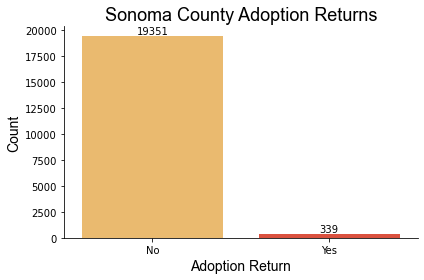

In [81]:
animal_copy_df = animal_df.copy()
animal_copy_df["adopt_return"] = animal_copy_df["adopt_return"].apply(lambda x: "Yes" if x == 1 else "No")
countplot = sns.countplot(x="adopt_return", data=animal_copy_df, palette='YlOrRd')
sns.despine(top=True, right=True)
plt.xlabel("Adoption Return", fontname="Arial", fontsize=14)
plt.ylabel("Count", fontname="Arial", fontsize=14)
plt.title("Sonoma County Adoption Returns", fontname="Arial", fontsize=18)

# plot numbers above the bar chart
for p in countplot.patches:
    height = p.get_height()
    countplot.text(p.get_x() + p.get_width()/2.,
                   height + 190,
                   '{:d}'.format(height),
                   ha='center')
plt.tight_layout()
plt.savefig('images/adoption_returns.png', format='png');

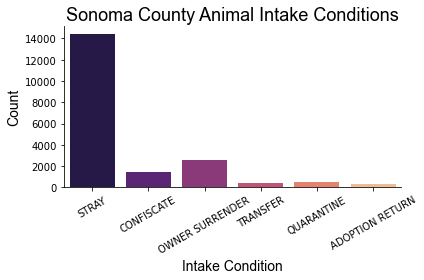

In [80]:
# plot all animal intake conditions
sns.countplot(x='intake_type', data=animal_df, palette='magma')
sns.despine(top=True, right=True)
plt.xlabel("Intake Condition", fontname="Arial", fontsize=14)
plt.ylabel("Count", fontname="Arial", fontsize=14)
plt.title("Sonoma County Animal Intake Conditions", fontname="Arial", fontsize=18)
plt.xticks(rotation=30)
plt.tight_layout()
plt.savefig('images/intake_conditions.png', format='png');

Now, I want to explore if there are other features that are more or less common in animals that are adoption returns.

In [3]:
def plot_cat_feature(feature, xlabel, xrotation=0, palette=''):
    '''
    This function takes a categorical feature and plots a bar chart comparing this feature between adoption returns
    and non-returns.
    Input:
    - feature (string): categorical feature name
    - xlabel (string): Label for x-axis and graph
    - xrotation (int): degree to rotate x-axis labels by
    - palette (string): name of color palette to use
    '''
    
    grouped_data = (animal_df[feature]
                    .groupby(animal_df["adopt_return"])
                    .value_counts(normalize=True) # normalize produces proportions
                    .rename("proportion")
                    .reset_index()
                    )
    fig, ax = plt.subplots()
    
    if palette:
        sns.barplot(data=grouped_data, x=feature, y="proportion", hue="adopt_return", palette=palette)
    else:
        sns.barplot(data=grouped_data, x=feature, y="proportion", hue="adopt_return")
    
    sns.despine(top=True, right=True)
    
    legend = ax.legend()
    legend.set_title("Adoption Return")
    legend.texts[0].set_text("No")
    legend.texts[1].set_text("Yes")
    
    plt.xlabel(xlabel, fontname="Arial", fontsize=14)
    plt.ylabel("Proportion", fontname="Arial", fontsize=14)
    plt.title(f'{xlabel} Proportions', fontname="Arial", fontsize=18)
    
    if xrotation:
        plt.xticks(rotation=xrotation)
    
    plt.tight_layout()
    plt.savefig(f'images/{feature}_proportions.png', format='png')
    
    plt.show();

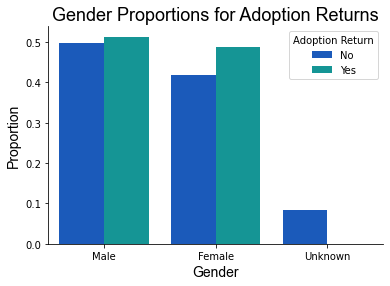

In [44]:
# Animals with unknown genders are always non-returns
plot_cat_feature("gender", "Gender", palette="winter")

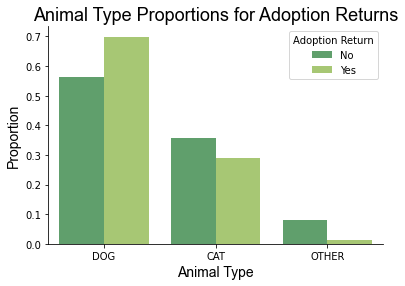

In [45]:
# Animals that are not dogs or cats are less likely to be adoption returns
plot_cat_feature("type", "Animal Type", palette='summer')

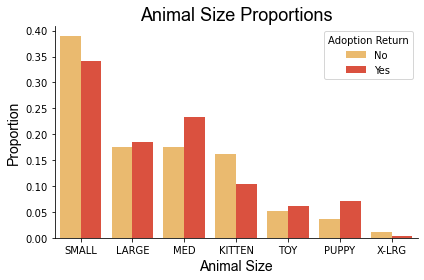

In [95]:
# Surprisingly, the size proportions are pretty even. I had expected extra large
# or large dogs to be more likely to be adoption returns
plot_cat_feature("size", "Animal Size", palette='YlOrRd')

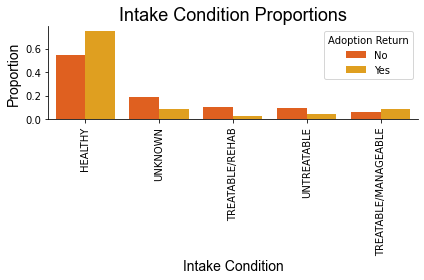

In [101]:
plot_cat_feature("intake_condition", "Intake Condition", xrotation=90, palette='autumn')

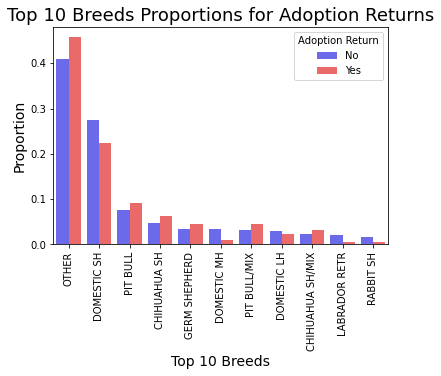

In [10]:
plot_cat_feature("top_breeds", "Top 10 Breeds", xrotation=90, palette='seismic')

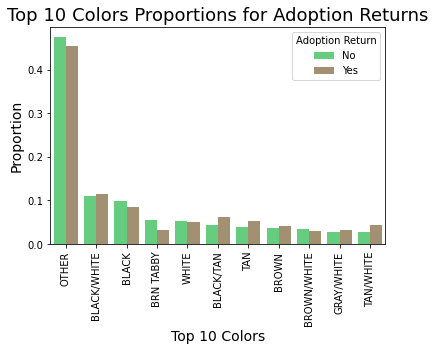

In [11]:
plot_cat_feature("top_colors", "Top 10 Colors", xrotation=90, palette='terrain')

Looking at intake location, there are a couple location that list adoption returns. However, I think this is due to a quirk in how the data is recorded. When "Intake Location" specifes "Sonoma County", it refers to that general area. Windosr, Petaluma, Rohnert Park, etc. are cities located within that county. <br/>

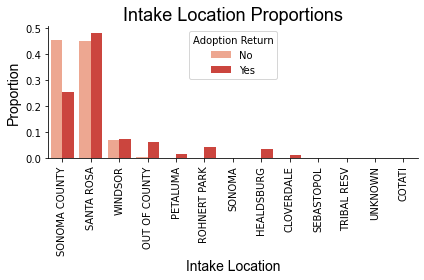

In [100]:
# it looks like there are certain cities where there's more likely to be adoption returns.
plot_cat_feature("intake_location", "Intake Location", xrotation=90, palette='Reds')

Not going to use anything regarding animal outcomes in my model because the outcome data cannot affect my target feature, which is an intake data (I can't predict the past from the future).

Over 70% of animals that were returned from adoption are re-adopted. That's great to see!

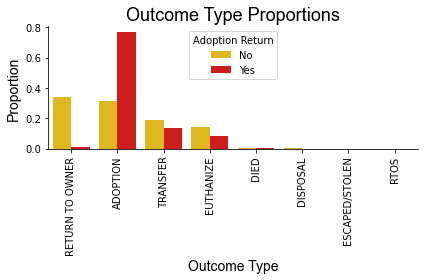

In [4]:
plot_cat_feature("outcome_type", "Outcome Type", xrotation=90, palette='hot_r')

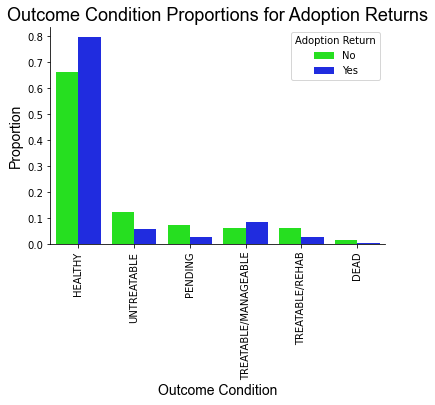

In [58]:
plot_cat_feature("outcome_condition", "Outcome Condition", xrotation=90, palette='hsv')

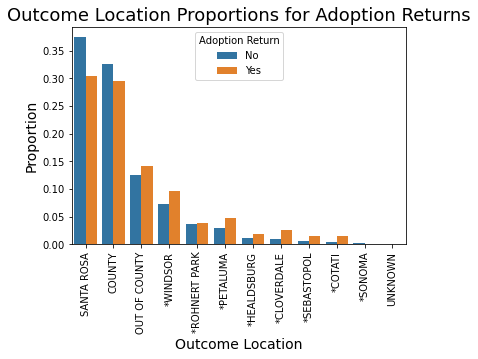

In [15]:
plot_cat_feature("outcome_jurisdiction", "Outcome Location", xrotation=90)

In [6]:
def plot_binary_feature(feature, xlabel, binary_label_1, binary_label_0, palette=''):
    '''
    This function takes a binary feature and plots a bar chart comparing this feature between adoption returns
    and non-returns.
    Input:
    - feature(string): binary feature name
    - xlabel (string): Label for x-axis and graph
    - binary_label_1 (string): Label to use instead of "1"
    - binary_label_0 (string): Label to use instead of "0"
    - palette (string): name of color palette to use
    '''
    animal_df_copy = animal_df.copy()
    animal_df_copy[feature] = animal_df_copy[feature].apply(lambda x: binary_label_1 if x == 1 else binary_label_0)
    
    grouped_data = (animal_df_copy[feature]
                    .groupby(animal_df_copy["adopt_return"])
                    .value_counts(normalize=True) # normalize produces proportions
                    .rename("proportion")
                    .reset_index()
                    )
    fig, ax = plt.subplots()
    
    if palette:
        sns.barplot(data=grouped_data, x=feature, y="proportion", hue="adopt_return", palette=palette)
    else:
        sns.barplot(data=grouped_data, x=feature, y="proportion", hue="adopt_return")
    
    sns.despine(top=True, right=True)
    
    legend = ax.legend(bbox_to_anchor=(1.04,1), loc="upper left")
    legend.set_title("Adoption Return")
    legend.texts[0].set_text("No")
    legend.texts[1].set_text("Yes")
    
    plt.xlabel(xlabel, fontname="Arial", fontsize=14)
    plt.ylabel("Proportion", fontname="Arial", fontsize=14)
    plt.title(f'{xlabel} Proportions', fontname="Arial", fontsize=18)
    
    plt.tight_layout()
    plt.savefig(f'images/{feature}_proportions.png', format='png')
    
    plt.show();

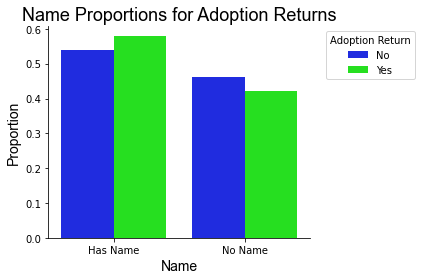

In [88]:
plot_binary_feature("has_name", "Name", "Has Name", "No Name", palette='hsv_r')

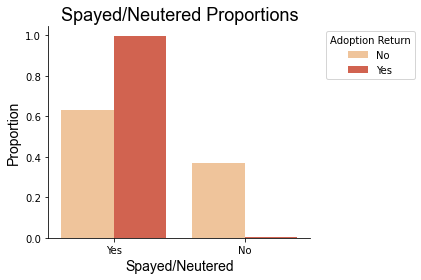

In [98]:
# not surprisingly, all animals that are returned from adoption have been spayed or neutered
plot_binary_feature("spay_neuter", "Spayed/Neutered", "Yes", "No", palette='OrRd')

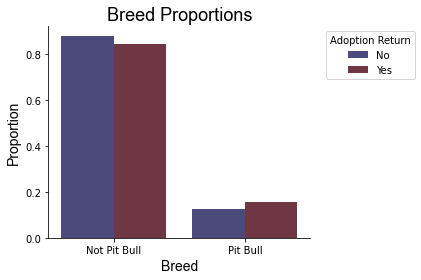

In [7]:
plot_binary_feature("pit_bull", "Breed", "Pit Bull", "Not Pit Bull", palette='icefire')

In [67]:
def plot_continuous_feature(feature, xlabel):
    '''
    This function takes a continuous and plots overlapping kde plots showing the difference between 
    adoption returns and non-returns.
    Input:
    - feature(string): continuous feature name
    - xlabel (string): Label for graph and x-axis
    '''
    
    adopt_return_df = animal_df[animal_df["adopt_return"] == 1].copy()
    no_return_df = animal_df[animal_df["adopt_return"] == 0].copy()
    
    sns.kdeplot(adopt_return_df[feature], color='r', label="Adoption Return")
    sns.kdeplot(no_return_df[feature], color='b', label="Other")
    sns.despine(top=True, right=True)

    plt.xlabel(xlabel, fontname='Arial', fontsize=14)
    plt.ylabel("PDF", fontname='Arial', fontsize=14)
    plt.title(f'{xlabel} Distributions for Adoption Returns', fontname='Arial', fontsize=18)
    
    plt.savefig(f'images/{feature}_distribution.png', format='png')
    
    plt.show();

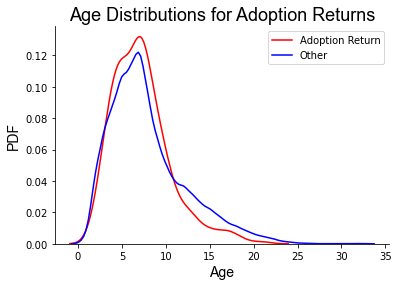

In [68]:
plot_continuous_feature("age", "Age")

### 3. Classification Pre-Work
I explore my data more and do a bit of pre-work before doing apply some classification models.

In [ ]:
adopt_return_df = animal_df[animal_df["intake_type"] == "ADOPTION RETURN"].copy()
no_return_df = animal_df[animal_df["intake_type"] != "ADOPTION RETURN"].copy()

In [4]:
adopt_return_top_breeds = adopt_return_df["breed"].value_counts().index.to_list()[:10]
adopt_return_top_breeds

['DOMESTIC SH',
 'PIT BULL',
 'CHIHUAHUA SH',
 'PIT BULL/MIX',
 'GERM SHEPHERD',
 'CHIHUAHUA SH/MIX',
 'DOMESTIC LH',
 'GERM SHEPHERD/MIX',
 'PARSON RUSS TER/MIX',
 'SIBERIAN HUSKY']

In [5]:
no_return_top_breeds = no_return_df["breed"].value_counts().index.to_list()[:10]
no_return_top_breeds

['DOMESTIC SH',
 'PIT BULL',
 'CHIHUAHUA SH',
 'GERM SHEPHERD',
 'DOMESTIC MH',
 'PIT BULL/MIX',
 'DOMESTIC LH',
 'CHIHUAHUA SH/MIX',
 'LABRADOR RETR',
 'RABBIT SH']

In [20]:
adopt_return_df["top_breeds"] = adopt_return_df["breed"].apply(lambda x: x if x in adopt_return_top_breeds else "Other")

In [21]:
no_return_df["top_breeds"] = no_return_df["breed"].apply(lambda x: x if x in no_return_top_breeds else "Other")

What are the features that I want to investigate and keep? What types of features are they?
* has_name: boolean value
* spay_neuter: boolean value
* gender: male or female or unknown
* age: integer value (there are lots of unknown values; might not be able to use logistic regression)
* intake_jursidiction: categorical (need to break down into top 10?)
* intake_condition: categorical (need to break down into top 10?)
* intake_subtype: categorical
* color: don't know if it matters too much; do the top 10 colors?
* size: small, medium, large, x-large, kitten, etc.
* breed: many different types
* type: dog, cat, or other

Target feature:
* intake_type: adoption return or other

In [20]:
classification_prep_df = animal_df[["has_name", "type", "size", "top_breeds", "spay_neuter", "gender", "age", \
                                    "intake_jurisdiction", "intake_condition", "intake_subtype", \
                                    "top_colors", "adopt_return"]].copy()
classification_prep_df["intake_jurisdiction"].replace({"COUNTY": "SONOMA"}, inplace=True)
classification_prep_df.head()

,has_name,type,size,top_breeds,spay_neuter,gender,age,intake_jurisdiction,intake_condition,intake_subtype,top_colors,adopt_return
0,1,DOG,MED,OTHER,0,Male,5.0,SANTA ROSA,UNKNOWN,FIELD,BROWN,0
1,0,DOG,MED,PIT BULL/MIX,0,Female,NaN,SONOMA,HEALTHY,FIELD,BLACK/WHITE,0
2,1,DOG,MED,GERM SHEPHERD,0,Female,NaN,SONOMA,HEALTHY,FIELD,BLACK/TAN,0
3,1,DOG,SMALL,OTHER,1,Male,6.0,SANTA ROSA,UNKNOWN,FIELD,OTHER,0
4,1,CAT,SMALL,DOMESTIC SH,1,Female,11.0,SONOMA,TREATABLE/MANAGEABLE,OVER THE COUNTER,BRN TABBY,0


In [14]:
classification_prep_df.nunique()

has_name                2
type                    3
size                    7
top_breeds             11
spay_neuter             2
gender                  3
age                    32
intake_jurisdiction    13
intake_condition        5
intake_subtype         25
top_colors             11
intake_type             6
adopt_return            2
dtype: int64

In [ ]:
# Save the classification prep data as a pickle file
classification_prep_df.to_pickle("data/classification_prep_df.pickle")

I have a ton of categorical variables. I'll need to decide which categorical variables to drop when I make dummy variables.

In [21]:
print(classification_prep_df["size"].value_counts()) # drop X-LRG size
print(classification_prep_df["type"].value_counts()) # drop other type
print(classification_prep_df["top_breeds"].value_counts()) #drop rabbit SH
print(classification_prep_df["gender"].value_counts()) # drop Unknown gender
print(classification_prep_df["intake_jurisdiction"].value_counts()) # drop Cotati county
print(classification_prep_df["intake_condition"].value_counts()) # drop TREATABLE/MANAGEABLE
print(classification_prep_df["intake_subtype"].value_counts()) # drop OVER_THE_COUNTER_OWNED
print(classification_prep_df["top_colors"].value_counts()) # drop Tan/white

SMALL    7623
MED      3476
LARGE    3468
KITTN    3158
TOY      1021
PUPPY     713
X-LRG     200
Name: size, dtype: int64
DOG      11127
CAT       7030
OTHER     1533
Name: type, dtype: int64
OTHER               8092
DOMESTIC SH         5415
PIT BULL            1514
CHIHUAHUA SH         942
GERM SHEPHERD        683
DOMESTIC MH          642
PIT BULL/MIX         641
DOMESTIC LH          570
CHIHUAHUA SH/MIX     467
LABRADOR RETR        416
RABBIT SH            308
Name: top_breeds, dtype: int64
Male       9794
Female     8259
Unknown    1637
Name: gender, dtype: int64
SANTA ROSA       8946
SONOMA           8899
*WINDSOR         1427
OUT OF COUNTY     140
*ROHNERT PARK      61
*PETALUMA          60
*HEALDSBURG        49
*SONOMA            42
*CLOVERDALE        26
*SEBASTOPOL        19
*TRIBAL RESV       12
UNKNOWN             5
*COTATI             4
Name: intake_jurisdiction, dtype: int64
HEALTHY                 10880
UNKNOWN                  3634
TREATABLE/REHAB          2045
UNTREATABL

In [24]:
# I didn't do anything with age null values and size null values
classification_prep_df = pd.get_dummies(classification_prep_df)
classification_prep_df.drop(columns=["type_OTHER", "size_X-LRG", "top_breeds_RABBIT SH", \
                                     "gender_Unknown", "intake_jurisdiction_*COTATI", "intake_condition_TREATABLE/MANAGEABLE", \
                                     "intake_subtype_OVER THE COUNTER_OWNED", "top_colors_TAN/WHITE"], inplace=True)
classification_prep_df.columns

Index(['has_name', 'spay_neuter', 'age', 'adopt_return', 'type_CAT',
       'type_DOG', 'size_KITTN', 'size_LARGE', 'size_MED', 'size_PUPPY',
       'size_SMALL', 'size_TOY', 'top_breeds_CHIHUAHUA SH',
       'top_breeds_CHIHUAHUA SH/MIX', 'top_breeds_DOMESTIC LH',
       'top_breeds_DOMESTIC MH', 'top_breeds_DOMESTIC SH',
       'top_breeds_GERM SHEPHERD', 'top_breeds_LABRADOR RETR',
       'top_breeds_OTHER', 'top_breeds_PIT BULL', 'top_breeds_PIT BULL/MIX',
       'gender_Female', 'gender_Male', 'intake_jurisdiction_*CLOVERDALE',
       'intake_jurisdiction_*HEALDSBURG', 'intake_jurisdiction_*PETALUMA',
       'intake_jurisdiction_*ROHNERT PARK', 'intake_jurisdiction_*SEBASTOPOL',
       'intake_jurisdiction_*SONOMA', 'intake_jurisdiction_*TRIBAL RESV',
       'intake_jurisdiction_*WINDSOR', 'intake_jurisdiction_OUT OF COUNTY',
       'intake_jurisdiction_SANTA ROSA', 'intake_jurisdiction_SONOMA',
       'intake_jurisdiction_UNKNOWN', 'intake_condition_HEALTHY',
       'intake_condi

In [26]:
classification_prep_df.head()

,has_name,spay_neuter,age,adopt_return,type_CAT,type_DOG,size_KITTN,size_LARGE,size_MED,size_PUPPY,...,top_colors_BLACK,top_colors_BLACK/TAN,top_colors_BLACK/WHITE,top_colors_BRN TABBY,top_colors_BROWN,top_colors_BROWN/WHITE,top_colors_GRAY/WHITE,top_colors_OTHER,top_colors_TAN,top_colors_WHITE
0,1,0,5.0,0,0,1,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
1,0,0,NaN,0,0,1,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
2,1,0,NaN,0,0,1,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
3,1,1,6.0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,1,1,11.0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [35]:
classification_prep_df["age"].fillna(classification_prep_df["age"].mean(), inplace=True)

In [36]:
X = classification_prep_df.copy().drop(columns="adopt_return")
y = classification_prep_df["adopt_return"].copy()
# stratify my train and test set because I have an imbalanced test variable
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y)

In [31]:
# double checking my test variable is stratified between train and test set
print(y_train.value_counts())
print(y_test.value_counts())

0    15480
1      272
Name: adopt_return, dtype: int64
0    3870
1      68
Name: adopt_return, dtype: int64


In [37]:
# testing out a basic Logistic Regression
logreg = LogisticRegression()
logreg.fit(x_train, y_train)
print(logreg.score(x_test, y_test))

0.9834941594718131


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



In [25]:
# save dummified dataframe
classification_prep_df.to_pickle("data/dummified_df.pickle")